<a href="https://colab.research.google.com/github/dantrainor9/Animal_Image_Classification/blob/main/Animal_Image_Classification_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from matplotlib.pyplot import imshow

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, Adamax

In [11]:
path = '/content/drive/MyDrive/Personal Projects/Animal Image Classification/dataset'

In [12]:
#defining a function for visualizing image samples from a generator
def show_image_samples(gen):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) #get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255        
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='green', fontsize=12)
        plt.axis('off')
    plt.show()

In [13]:
#defining a function for visualizing images from a directory
def show_images(mydir):
    classlist=os.listdir(mydir)
    length=len(classlist)
    columns=5
    rows=int(np.ceil(length/columns))    
    plt.figure(figsize=(20, rows * 4))
    for i, klass in enumerate(classlist):    
        classpath=os.path.join(mydir, klass)
        imgpath=os.path.join(classpath, '1.jpg')
        img=plt.imread(imgpath)
        plt.subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title(klass, color='green', fontsize=12)
        plt.imshow(img)

In [14]:
#defining a function for preprocessing of images into dataframes
def preprocess (sdir, trsplit, vsplit):
    filepaths=[]
    labels=[]    
    classlist=os.listdir(sdir)
    for class1 in classlist:
        classpath=os.path.join(sdir,class1)
        if os.path.isdir(classpath):
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(class1)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)            
    dsplit=vsplit/(1-trsplit)
    strat=df['labels']
    train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat)
    strat=dummy_df['labels']
    valid_df, test_df= train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
    #check that each dataframe has the same number of classes to prevent model.fit errors
    trcount=len(train_df['labels'].unique())
    tecount=len(test_df['labels'].unique())
    vcount=len(valid_df['labels'].unique())
    if trcount < tecount :         
        msg='** WARNING ** number of classes in training set is less than the number of classes in test set'
        print_in_color(msg, (255,0,0), (55,65,80))
        msg='This will throw an error in either model.evaluate or model.predict'
        print_in_color(msg, (255,0,0), (55,65,80))
    if trcount != vcount:
        msg='** WARNING ** number of classes in training set not equal to number of classes in validation set' 
        print_in_color(msg, (255,0,0), (55,65,80))
        msg=' this will throw an error in model.fit'
        print_in_color(msg, (255,0,0), (55,65,80))
        print ('train df class count: ', trcount, 'test df class count: ', tecount, ' valid df class count: ', vcount) 
        ans=input('Enter C to continue execution or H to halt execution')
        if ans =='H' or ans == 'h':
            print_in_color('Halting Execution', (255,0,0), (55,65,80))
            import sys
            sys.exit('program halted by user')            
    print(list(train_df['labels'].value_counts()))
    return train_df, test_df, valid_df

Image shape is  (224, 224, 3)


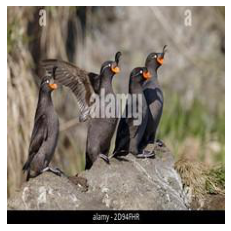

In [15]:
#printing an image to ensure data is stored and loaded correctly
img_path='/content/drive/MyDrive/Personal Projects/Animal Image Classification/dataset/aethia-cristatella/aethia-cristatella_100_f0be0d50.jpg'
img=plt.imread(img_path)
print ('Image shape is ',img.shape)
plt.axis('off')
imshow(img)

In [16]:
preprocess(path, 0.7,0.15)

train_df length:  4389   test_df length:  941   valid_df length:  940
[42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 41, 41, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 34, 34, 34, 34, 33, 32, 31, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 20, 20, 20, 20, 20, 20, 20, 19, 18]


(                                              filepaths                 labels
 4724  /content/drive/MyDrive/Personal Projects/Anima...         pavo-cristatus
 2163  /content/drive/MyDrive/Personal Projects/Anima...         crotalus-atrox
 4239  /content/drive/MyDrive/Personal Projects/Anima...  pantherophis-guttatus
 3446  /content/drive/MyDrive/Personal Projects/Anima...   melanerpes-carolinus
 4024  /content/drive/MyDrive/Personal Projects/Anima...           orcinus-orca
 ...                                                 ...                    ...
 3109  /content/drive/MyDrive/Personal Projects/Anima...        icterus-gularis
 3658  /content/drive/MyDrive/Personal Projects/Anima...            lemur-catta
 1025  /content/drive/MyDrive/Personal Projects/Anima...  cardinalis-cardinalis
 827   /content/drive/MyDrive/Personal Projects/Anima...  centruroides-vittatus
 1095  /content/drive/MyDrive/Personal Projects/Anima...      branta-canadensis
 
 [4389 rows x 2 columns],
            